In [2]:
import os
import faiss
import torch
import skimage
import requests
import pinecone
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
import datasets
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from clip_embeddings import get_dataset, plot_images_by_side, CLIPModelPinecone


my_index_name = "clip-image-search"

# pinecone.delete_index(my_index_name)


## Setup CLIP Model and pinecone index for search

In [3]:
image_data = get_dataset("/usr/src/app/data/dataset/train_images/files.txt")
image_data_df = image_data.with_format("torch")

clip_model = CLIPModelPinecone(model_ID="openai/clip-vit-base-patch32")

image_data_df = clip_model.get_all_images_embedding(image_data_df, "image")

clip_model.process_df_to_pinecone(image_data_df)

500
500


## Query with a new image

In [22]:
image_query = image_data_df[200]['image']

In [23]:
query_embedding = clip_model.get_single_image_embedding(image_query).tolist()
result = clip_model.search_pinecone(query_embedding, top_K=4)['matches']

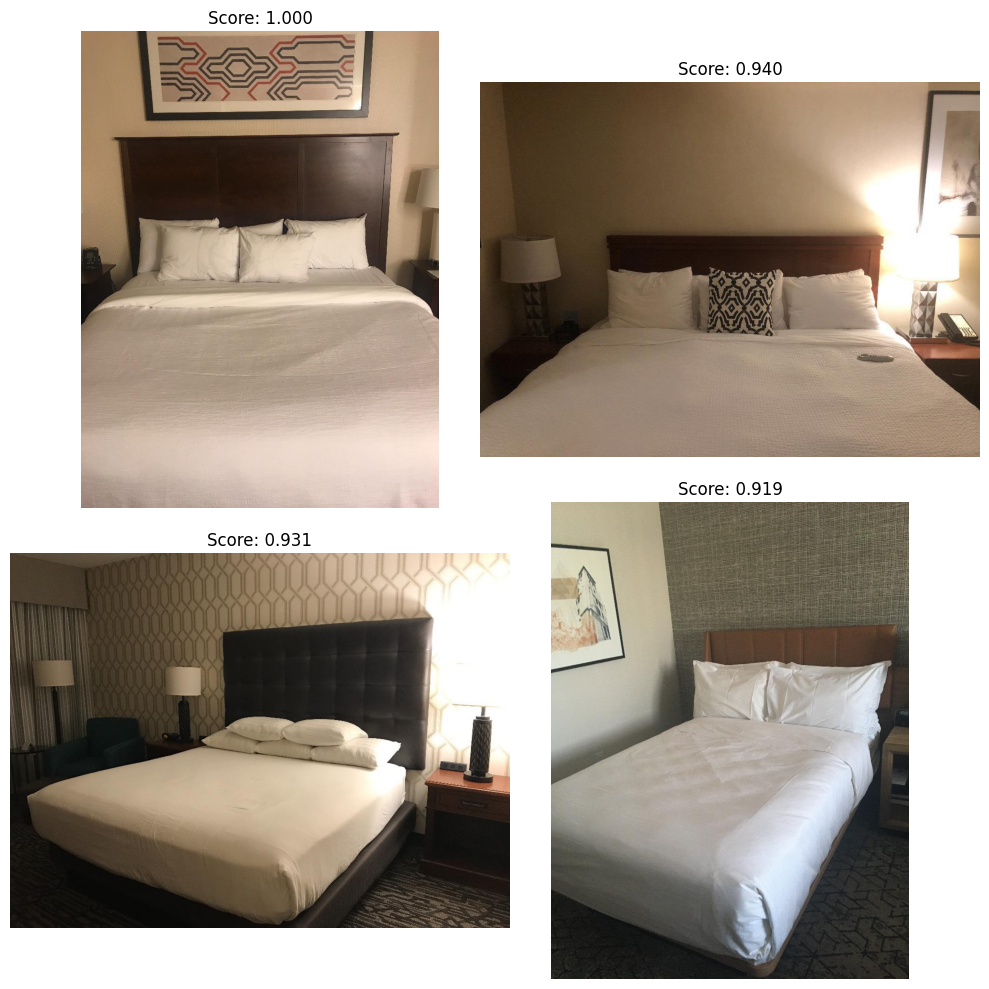

In [24]:
clip_model.plot_result(result)

## Query with text

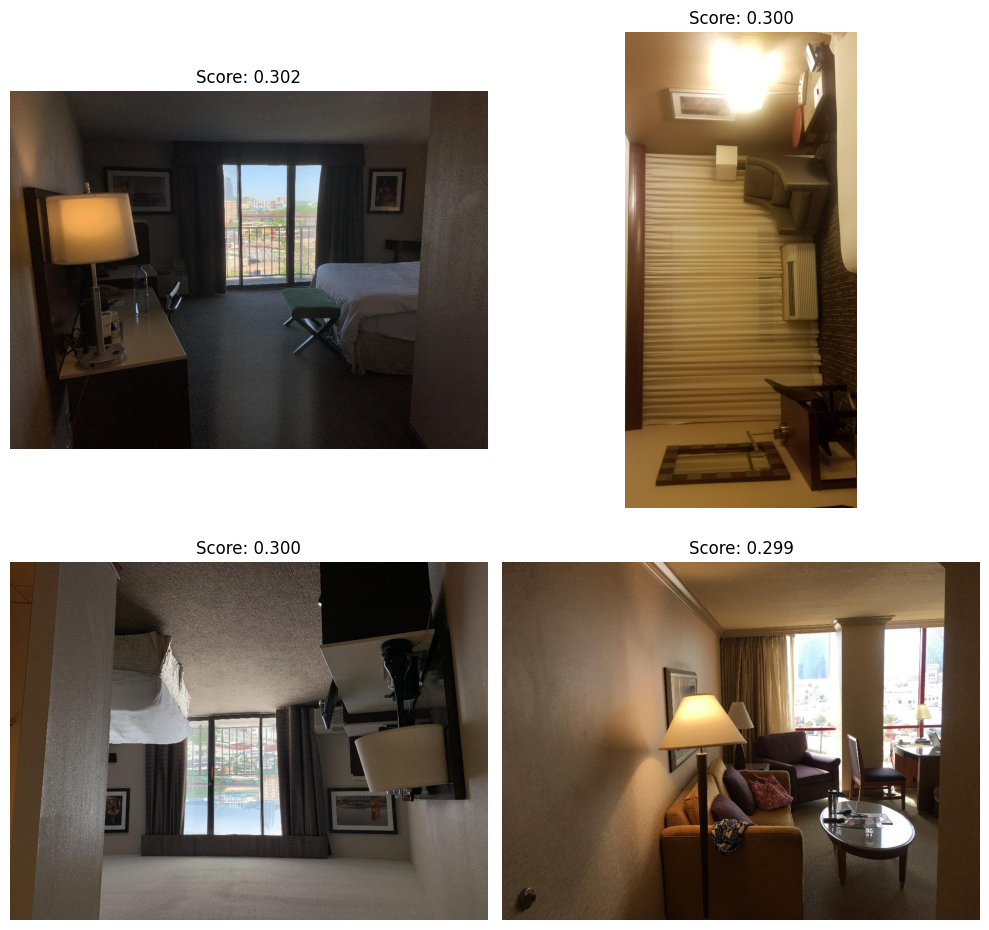

In [25]:
text_query = "hotel room with balcony"

# Get the caption embedding
query_embedding = clip_model.get_single_text_embedding(text_query).tolist()
 
# Run the query
result = clip_model.search_pinecone(query_embedding, top_K=4)['matches']

clip_model.plot_result(result)


In [1]:
import glob

list_files = glob.glob('/usr/src/app/data/dataset/train_images/*/*.jpg')
file = open('/usr/src/app/data/dataset/train_images/files.txt','w')
for item in list_files[:500]:
	file.write(item+"\n")
file.close()

# Deprecated

In [4]:
# import glob
# glob.glob('/usr/src/app/data/train/*')
# Open the file in read mode
from datasets import load_dataset, Image, Dataset
with open('/usr/src/app/data/train/files.txt', 'r') as f:
    # Read lines into a list
    lines = f.read().splitlines()

# Convert the list into a dictionary
dict_files = {'image_url': lines, 'image': lines}
print(dict_files)
dict_files = pd.DataFrame.from_dict(dict_files)
image_data = Dataset.from_pandas(dict_files).cast_column("image", Image())


# image_data = load_dataset("imagefolder", data_dir="/usr/src/app/data")

{'image_url': ['/usr/src/app/data/train/99e91ad5f2870678.jpg', '/usr/src/app/data/train/03.jpeg', '/usr/src/app/data/train/05.jpg', '/usr/src/app/data/train/b5cc62ab665591a9.jpg', '/usr/src/app/data/train/01.jpg', '/usr/src/app/data/train/02.jpg', '/usr/src/app/data/train/04.jpg', '/usr/src/app/data/train/d5664a972d5a644b.jpg'], 'image': ['/usr/src/app/data/train/99e91ad5f2870678.jpg', '/usr/src/app/data/train/03.jpeg', '/usr/src/app/data/train/05.jpg', '/usr/src/app/data/train/b5cc62ab665591a9.jpg', '/usr/src/app/data/train/01.jpg', '/usr/src/app/data/train/02.jpg', '/usr/src/app/data/train/04.jpg', '/usr/src/app/data/train/d5664a972d5a644b.jpg']}


In [5]:
def get_model_info(model_ID, device):
# Save the model to device
	model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
	processor = CLIPProcessor.from_pretrained(model_ID)
# Get the tokenizer
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
       # Return model, processor & tokenizer
	return model, processor, tokenizer
# Set the device
device = "cuda" if torch.cuda.is_available() else "CPU"
# device = "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

In [6]:
def get_single_text_embedding(text): 
    inputs = tokenizer(text, return_tensors = "pt")
    inputs['input_ids'] = inputs['input_ids'].to(device)
    inputs['attention_mask'] = inputs['attention_mask'].to(device)
    
    print("keys: ",inputs.keys())
    print(model.device)
    text_embeddings = model.get_text_features(**inputs)
    # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np
def get_all_text_embeddings(df, text_col):
    df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)
    return df
# Apply the functions to the dataset

# image_data_df = get_all_text_embeddings(image_data_df["train"], "caption")

In [7]:
def get_single_image_embedding(my_image):
    image = processor(
    		text = None,
    		images = my_image,
    		return_tensors="pt"
    		)["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np
    
def get_all_images_embedding(df, img_column):
    embeddings = []
    for b in df:
        embeddings.append(get_single_image_embedding(b["image"]))
    print(len(embeddings))

    dset_embed = datasets.Dataset.from_dict({"img_embeddings": embeddings})
    dset_concat = datasets.concatenate_datasets([df, dset_embed], axis=1)
    print(len(dset_concat))
    return dset_concat
    
image_data_df = image_data.with_format("torch")

# print(image_data_df["train"]["image"])

image_data_df = get_all_images_embedding(image_data_df, "image")

8
8


In [8]:
embeddings = np.array(image_data_df["img_embeddings"])
print(embeddings.shape)
# print((embeddings[0]))


(8, 1, 512)


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
def get_top_N_images(query, data, top_K=5, search_criterion="text"):
    # Text to image Search
    if(search_criterion.lower() == "text"):
        query_vect = get_single_text_embedding(query)
    # Image to image Search
    else:
        query_vect = get_single_image_embedding(query)
    print("query_vect: ", type(query_vect))
    print("query_vect: ", query_vect.shape)
    # Relevant columns
    revevant_cols = ["image", "cos_sim"]
    # Run similarity Search
    cos_sim = np.array([cosine_similarity(query_vect,x)[0,0] for x in np.array(data["img_embeddings"])[:,:,:]])
    print(cos_sim.shape)

    cos_sim = datasets.Dataset.from_dict({"cos_sim": cos_sim})
    data = datasets.concatenate_datasets([data, cos_sim], axis=1)
    
    # data["cos_sim"] = pd.DataFrame(np.array(data["img_embeddings"])[:,0,:]).apply(lambda x: cosine_similarity(query_vect, x))# line 17
    # data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
    """
    Retrieve top_K (4 is default value) articles similar to the query
    """
    most_similar_articles = data.sort('cos_sim',  reverse=True)[1:top_K+1] # line 24
    most_similar_articles = pd.DataFrame.from_dict(most_similar_articles)
    return most_similar_articles.reset_index()

In [10]:
def plot_images_by_side(top_images):
    index_values = list(top_images.index.values)
    list_images = [top_images.iloc[idx].image for idx in index_values]
    similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]
    n_row = n_col = 2
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax, sim_score in zip(list_images, axs, similarity_score):
        ax.imshow(img)
        sim_score = 100*float("{:.2f}".format(sim_score))
        caption = "1"
        ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
    plt.show()

Query: hotel room with big window
keys:  dict_keys(['input_ids', 'attention_mask'])
cuda:0
query_vect:  <class 'numpy.ndarray'>
query_vect:  (1, 512)
(8,)


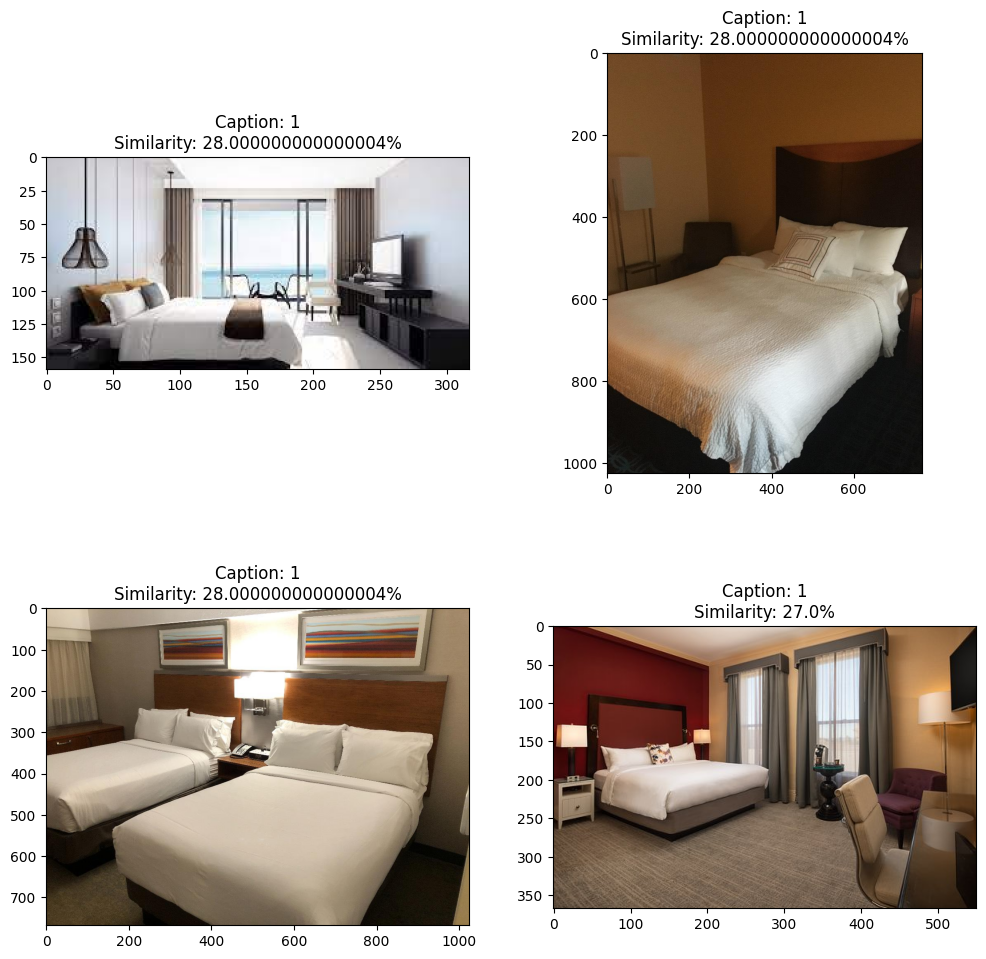

In [11]:
query_caption = "hotel room with big window"
# Print the original query text
print("Query: {}".format(query_caption))
# Run the similarity search
top_images = get_top_N_images(query_caption, image_data_df)
# Plot the recommended images
plot_images_by_side(top_images)

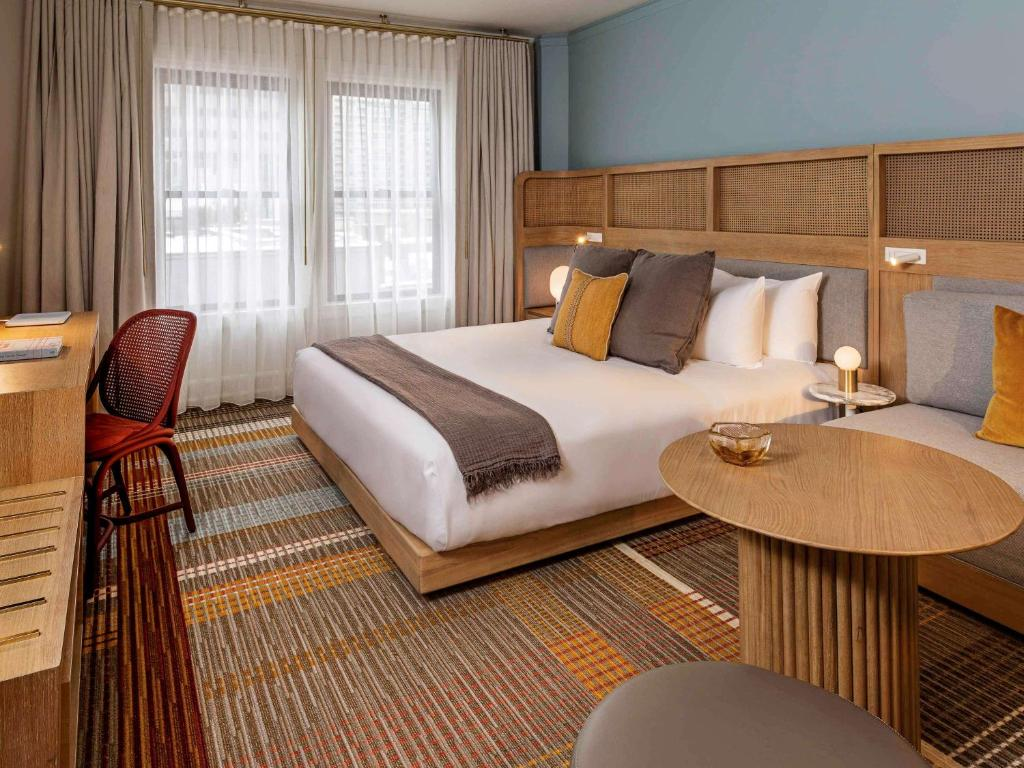

In [12]:
# Get the query image and show it
query_image = image_data_df[2]['image']
query_image



query_vect:  <class 'numpy.ndarray'>
query_vect:  (1, 512)
(8,)


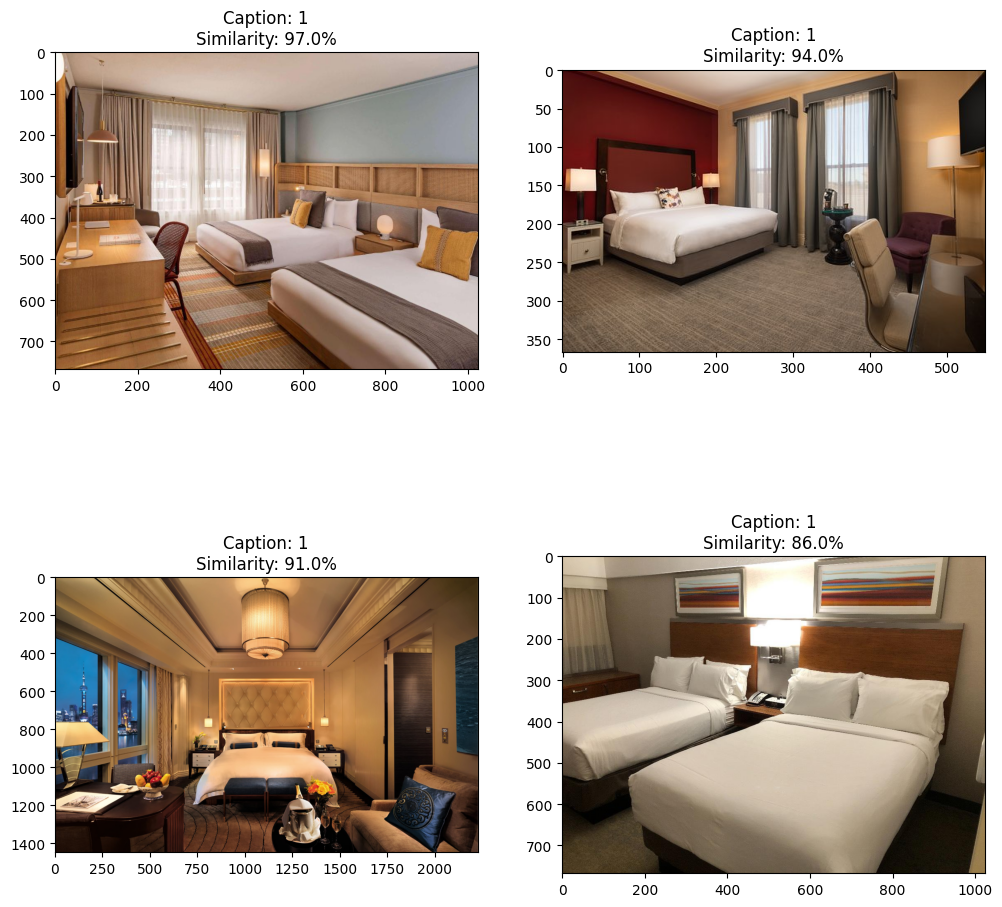

In [13]:
# Run the similarity search and plot the result
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
# Plot the result
plot_images_by_side(top_images)

# Start from sratch

In [14]:
pinecone.init(
   api_key = "15fcf7e5-64b1-4d95-8269-ad95dd17a740",
   environment="asia-southeast1-gcp-free"  # find next to API key in console
)
my_index_name = "clip-image-search"
vector_dim = 512
 
if my_index_name not in pinecone.list_indexes():
    # Create the vectors dimension
    pinecone.create_index(name = my_index_name,
                           dimension=vector_dim,
                           metric="cosine", shards=1,
                           pod_type='s1.x1')
# Connect to the index
my_index = pinecone.Index(index_name = my_index_name)

In [15]:
my_index.describe_index_stats()

ServiceException: (503)
Reason: Service Unavailable
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain', 'content-length': '19', 'date': 'Sun, 18 Jun 2023 09:11:12 GMT', 'server': 'envoy', 'connection': 'close'})
HTTP response body: no healthy upstream


In [ ]:
df_urls = pd.DataFrame(image_data_df["image_url"])
df_urls = list(df_urls.index)
df_urls = [str(x) for x in df_urls]
vector_id = datasets.Dataset.from_dict({"vector_id": df_urls})
image_data_df = datasets.concatenate_datasets([image_data_df, vector_id], axis=1)


In [16]:
final_metadata = []
for index in range(len(image_data_df)):
 final_metadata.append({
     'ID':  index,
     'image': image_data_df[index]['image_url']
 })

In [18]:
image_IDs = image_data_df['vector_id']

In [34]:
image_embeddings = [arr for arr in image_data_df['img_embeddings']]
data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))


In [35]:
# Upload the final data
my_index.upsert(vectors = data_to_upsert)
# Check index size for each namespace
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 8}},
 'total_vector_count': 8}

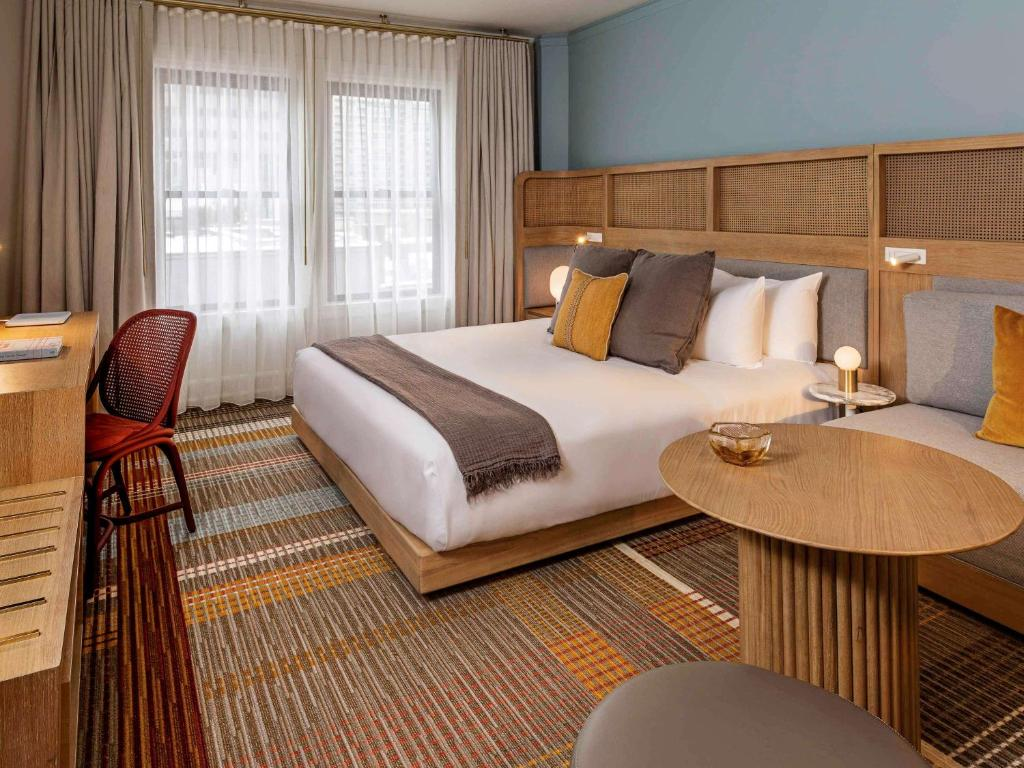

In [40]:
image_query = image_data_df[2]['image']
image_query

In [41]:
query_embedding = get_single_image_embedding(image_query).tolist()
my_index.query(query_embedding, top_k=4, include_metadata=True)


{'matches': [{'id': '2',
              'metadata': {'ID': 2.0,
                           'image': '/usr/src/app/data/train/05.jpg'},
              'score': 1.0,
              'values': []},
             {'id': '6',
              'metadata': {'ID': 6.0,
                           'image': '/usr/src/app/data/train/04.jpg'},
              'score': 0.966974139,
              'values': []},
             {'id': '4',
              'metadata': {'ID': 4.0,
                           'image': '/usr/src/app/data/train/01.jpg'},
              'score': 0.935608,
              'values': []},
             {'id': '5',
              'metadata': {'ID': 5.0,
                           'image': '/usr/src/app/data/train/02.jpg'},
              'score': 0.912682533,
              'values': []}],
 'namespace': ''}

In [3]:
pinecone.delete_index(my_index_name)

NameError: name 'my_index_name' is not defined

In [ ]:
import io
import PIL
import duckdb
import lancedb

In [9]:
# remove null prompts
import lance
import pyarrow.compute as pc

# download s3://eto-public/datasets/diffusiondb/small_10k.lance to this uri
data = lance.dataset("/usr/src/app/image_matching/output").to_table()

# First data processing and full-text-search index
db = lancedb.connect("~/datasets/demo")
tbl = db.create_table("diffusiondb", data.filter(~pc.field("image").is_null()))



In [10]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast

MODEL_ID = "openai/clip-vit-base-patch32"

tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()[0]

In [11]:
def find_image_vectors(query):
    emb = embed_func(query)
    code = (
        "import lancedb\n"
        "db = lancedb.connect('~/datasets/demo')\n"
        "tbl = db.open_table('diffusiondb')\n\n"
        f"embedding = embed_func('{query}')\n"
        "tbl.search(embedding).limit(1).to_df()"
    )
    return (_extract(tbl.search(emb).limit(1).to_df()), code)

def find_image_keywords(query):
    code = (
        "import lancedb\n"
        "db = lancedb.connect('~/datasets/demo')\n"
        "tbl = db.open_table('diffusiondb')\n\n"
        f"tbl.search('{query}').limit(1).to_df()"
    )
    return (_extract(tbl.search(query).limit(1).to_df()), code)

def find_image_sql(query):
    code = (
        "import lancedb\n"
        "import duckdb\n"
        "db = lancedb.connect('~/datasets/demo')\n"
        "tbl = db.open_table('diffusiondb')\n\n"
        "diffusiondb = tbl.to_lance()\n"
        f"duckdb.sql('{query}').to_df()"
    )    
    diffusiondb = tbl.to_lance()
    return (_extract(duckdb.sql(query).to_df()), code)

def _extract(df):
    image_col = "image"
    return [(PIL.Image.open(io.BytesIO(row[image_col])),"1") for _, row in df.iterrows()]

In [12]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast

MODEL_ID = "openai/clip-vit-base-patch32"

tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()[0]

In [13]:
import gradio as gr


with gr.Blocks() as demo:
    with gr.Row():
        with gr.Tab("Embeddings"):
            vector_query = gr.Textbox(value="portraits of a person", show_label=False)
            b1 = gr.Button("Submit")
        with gr.Tab("Keywords"):
            keyword_query = gr.Textbox(value="ninja turtle", show_label=False)
            b2 = gr.Button("Submit")
        with gr.Tab("SQL"):
            sql_query = gr.Textbox(value="SELECT * from diffusiondb WHERE image_nsfw >= 2 LIMIT 1", show_label=False)
            b3 = gr.Button("Submit")
    with gr.Row():
        code = gr.Code(label="Code", language="python")
    with gr.Row():
        gallery = gr.Gallery(
                label="Found images", show_label=False, elem_id="gallery"
            ).style(columns=[3], rows=[3], object_fit="contain", height="auto")   
        
    b1.click(find_image_vectors, inputs=vector_query, outputs=[gallery, code])
    b2.click(find_image_keywords, inputs=keyword_query, outputs=[gallery, code])
    b3.click(find_image_sql, inputs=sql_query, outputs=[gallery, code])
    
demo.launch()

/usr/local/lib/python3.8/dist-packages/gradio/components/gallery.py:205: UserWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/gradio/routes.py", line 437, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.8/dist-packages/gradio/blocks.py", line 1352, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.8/dist-packages/gradio/blocks.py", line 1077, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.8/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.8/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.8/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = context.run(func, *args)
  File "/tmp/ipykernel_3281/425817611.py", line 19, in find_image_keywords
    return (_extract(tbl.search(query).limit(1).to_df())

In [3]:
dataset = load_dataset("imagefolder", data_dir="/usr/src/app/data")

NameError: name 'load_dataset' is not defined

In [8]:
print(len(dataset))

1


dict_keys(['image'])
2


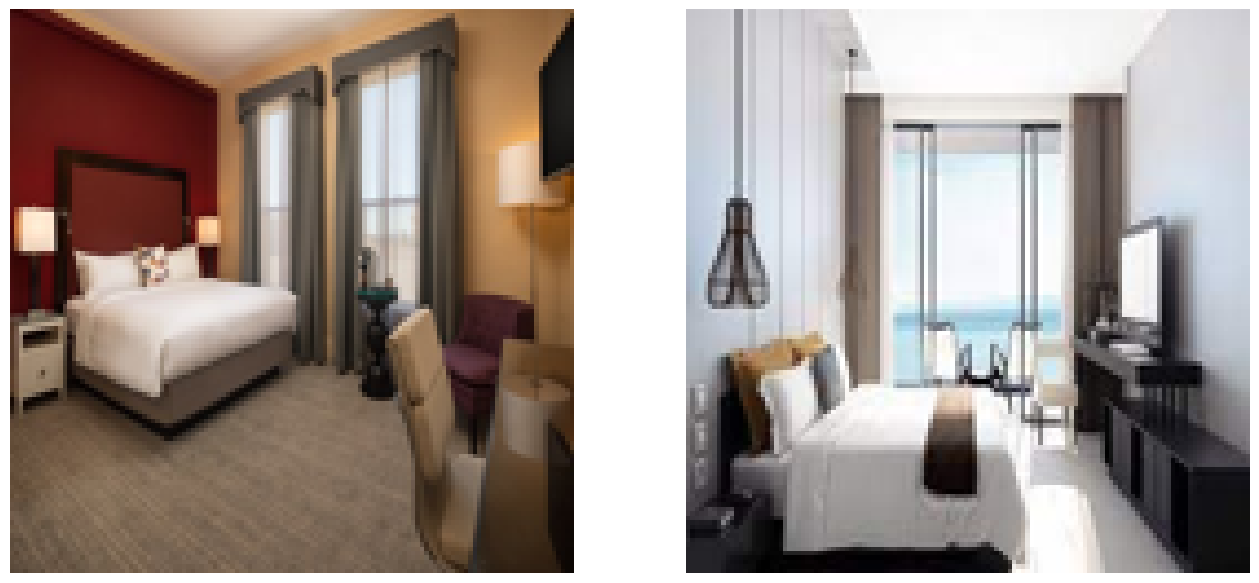

In [9]:
dataset = ImageDataset('/usr/src/app/data', image_size=(128, 128))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, drop_last=True)

# To get a batch of images as a PyArrow table:
for batch in dataloader:
    print(batch.keys())
    print(len(batch['image']))

    images = batch["image"]
    plt.figure(figsize=(16, 16))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

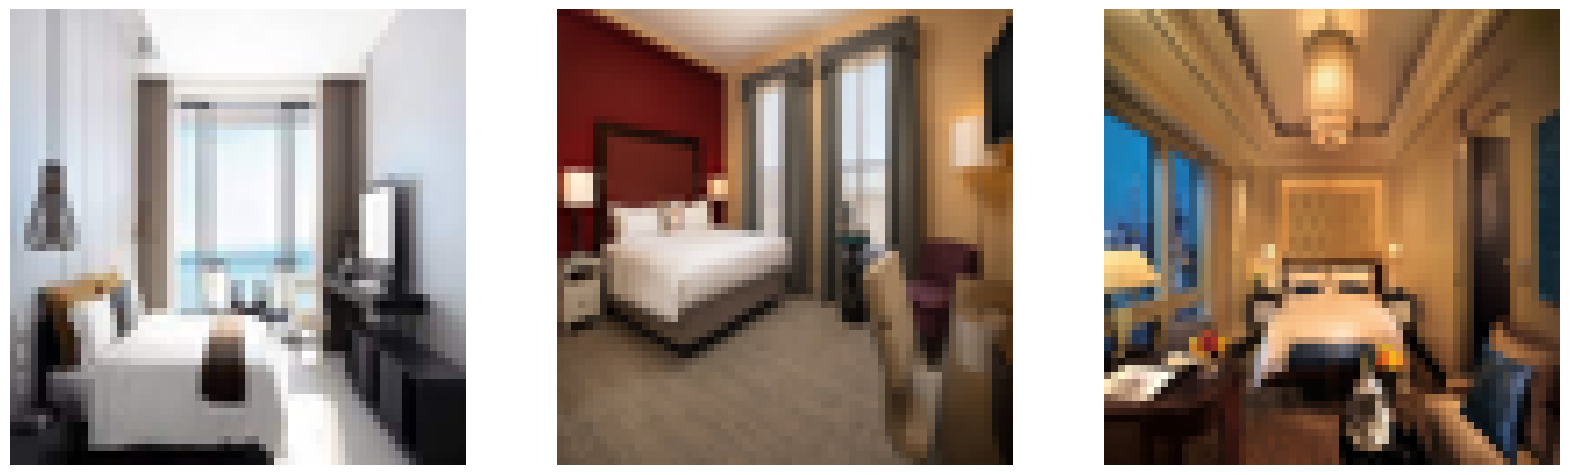

In [3]:
def load_and_resize_images(directory_path, image_size=(64, 64)):
    # Get list of image file names in the directory
    image_filenames = os.listdir(directory_path)
    images = []

    for image_filename in image_filenames:
        # Open each image
        image_path = os.path.join(directory_path, image_filename)
        with Image.open(image_path) as img:
            # Resize the image and convert it to RGB
            img = img.resize(image_size).convert("RGB")
            images.append(img)
    
    return images

# Usage
resized_images = load_and_resize_images('/usr/src/app/data', image_size=(64, 64))

# Plotting
num_images = len(resized_images)
plt.figure(figsize=(20, 20))

for i, image in enumerate(resized_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [3]:
# remove null prompts
import lance
import pyarrow.compute as pc

# download s3://eto-public/datasets/diffusiondb/small_10k.lance to this uri
data = lance.dataset("~/datasets/rawdata.lance").to_table()

# First data processing and full-text-search index
db = lancedb.connect("~/datasets/demo")
tbl = db.create_table("diffusiondb", data.filter(~pc.field("prompt").is_null()))
tbl = tbl.create_fts_index(["prompt"])

ValueError: Dataset at path root/datasets/rawdata.lance/_latest.manifest was not found: Not found: root/datasets/rawdata.lance/_latest.manifest